# Loading lib and Establishing connection to DWH

In [436]:
import pandas as pd
import numpy as np
import plotly.express as px
import os 
import json
import sys

from functools import lru_cache

from botocore.exceptions import ClientError

In [437]:
# Tells the location of folders (e.g. aws folder) - creates a path
from user_path import set_up_path 

PATH = set_up_path()
sys.path.append(PATH['tools'])
sys.path.append(PATH['tools'] + '/functions')


In [438]:
# Importing custom libraries to connect to DWS and GSheet
from functions.database import get_data_from_warehouse
from utils.gspread.gsheet_data import GetSheetData

# Quick EDA

In [523]:
# CA and pool onboarded drivers worked in 
query = """


SELECT d.stuart_driver_id,
  --     d.applicant_fountain_id,
       uam.application_fountain_id,
       uam.postcode_found as driver_postCode,
       uam.application_pool,
       a.area_name_uscore,
   --    a.area_name_cap,
       a.area_name_clean,
       a.catchment_area,
       uam.lat as lat_driver, ---- Just in case
       uam.long as long_driver---- Just in case
 --      z.zone_name

FROM dim.driver d

INNER JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = d.applicant_fountain_id

LEFT JOIN ops.area a
    ON uam.application_pool = a.area_name_uscore

WHERE d.zone_id = 2
AND d.is_active = TRUE

"""
courier_mapping = get_data_from_warehouse(query)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [440]:
courier_mapping

,stuart_driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,lat_driver,long_driver
0,368356,e12c514a-6b03-441d-ba8e-a5e219344509,NW1 4EP,Camden,Camden,Camden,London Inner N,51.528979,-0.144053
1,377271,1035def8-36c8-4d4c-a128-907407902dd8,NW10 0PT,Wembley,Wembley,Wembley,London Outer Upper NW,51.548382,-0.265571
2,350469,828b7ec6-c69c-402c-999e-45e047ac488a,SW19 2PE,Mitcham,Mitcham,Mitcham,London Inner S,51.413468,-0.178373
3,347430,1e2231e8-715e-4299-b24c-ba838cb170fc,NW9 5BD,Colindale,Colindale,Colindale,London Outer Upper NW,51.597835,-0.247690
4,348192,fa1628ec-22f1-47cb-a031-971aa31e27e1,SE19 3JB,Norwood,Norwood,Norwood,London Outer S,51.416369,-0.103304
...,...,...,...,...,...,...,...,...,...
10339,481487,a1c30eb5-4f5b-47c2-8105-3688fbd6ba51,WD18 6LE,not_in_a_pool,None,None,None,51.644343,-0.416763
10340,485455,f5689118-c11d-4b3b-b578-497cefbc42c4,HA1 4EN,Harrow_Central,Harrow_Central,Harrow Central,London Outer Upper NW,51.580134,-0.347857
10341,466380,a1c0d761-50a6-4be7-baaa-54ca7c3c8592,BR6 0JR,Orpington,Orpington,Orpington,London Outer SE,51.378243,0.101013
10342,479003,59ecb0d5-75e6-48d0-b7e1-1244d0c8b14f,OL10 1DW,not_in_a_pool,None,None,None,53.589642,-2.211868


In [441]:
courier_mapping.describe()

,stuart_driver_id,lat_driver,long_driver
count,10344.000000,10278.000000,10278.000000
mean,424786.822796,51.535681,-0.167630
std,46225.980437,0.292850,0.416792
min,339072.000000,50.339817,-4.978623
25%,390031.000000,51.449448,-0.250350
50%,415151.000000,51.523271,-0.106896
75%,469647.250000,51.568721,-0.011500
max,496865.000000,56.127844,1.122188


In [442]:
courier_mapping.isnull().sum()

stuart_driver_id              0
application_fountain_id       0
driver_postcode               0
application_pool              0
area_name_uscore           1058
area_name_clean            1058
catchment_area             1058
lat_driver                   66
long_driver                  66
dtype: int64

In [443]:
# Percentage of couriers not living in CA in London
not_in_CA = courier_mapping['catchment_area'].isnull().sum() * 100 / len(courier_mapping.catchment_area)
print(not_in_CA)

10.22815158546017


In [444]:
# Percentage of couriers living in CA in London
in_CA = courier_mapping['catchment_area'].notnull().sum() * 100 / len(courier_mapping.catchment_area)
print(in_CA)

89.77184841453983


In [445]:
courier_inCA = courier_mapping

In [446]:
courier_mapping['in_CA']= np.where(courier_mapping['catchment_area'].notnull() , 'Yes' , 'No')
courier_mapping

,stuart_driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,lat_driver,long_driver,in_CA
0,368356,e12c514a-6b03-441d-ba8e-a5e219344509,NW1 4EP,Camden,Camden,Camden,London Inner N,51.528979,-0.144053,Yes
1,377271,1035def8-36c8-4d4c-a128-907407902dd8,NW10 0PT,Wembley,Wembley,Wembley,London Outer Upper NW,51.548382,-0.265571,Yes
2,350469,828b7ec6-c69c-402c-999e-45e047ac488a,SW19 2PE,Mitcham,Mitcham,Mitcham,London Inner S,51.413468,-0.178373,Yes
3,347430,1e2231e8-715e-4299-b24c-ba838cb170fc,NW9 5BD,Colindale,Colindale,Colindale,London Outer Upper NW,51.597835,-0.247690,Yes
4,348192,fa1628ec-22f1-47cb-a031-971aa31e27e1,SE19 3JB,Norwood,Norwood,Norwood,London Outer S,51.416369,-0.103304,Yes
...,...,...,...,...,...,...,...,...,...,...
10339,481487,a1c30eb5-4f5b-47c2-8105-3688fbd6ba51,WD18 6LE,not_in_a_pool,None,None,None,51.644343,-0.416763,No
10340,485455,f5689118-c11d-4b3b-b578-497cefbc42c4,HA1 4EN,Harrow_Central,Harrow_Central,Harrow Central,London Outer Upper NW,51.580134,-0.347857,Yes
10341,466380,a1c0d761-50a6-4be7-baaa-54ca7c3c8592,BR6 0JR,Orpington,Orpington,Orpington,London Outer SE,51.378243,0.101013,Yes
10342,479003,59ecb0d5-75e6-48d0-b7e1-1244d0c8b14f,OL10 1DW,not_in_a_pool,None,None,None,53.589642,-2.211868,No


In [447]:
in_CA = courier_mapping.groupby('in_CA').agg({'stuart_driver_id':'count'}).reset_index()
in_CA

,in_CA,stuart_driver_id
0,No,1058
1,Yes,9286


In [448]:
# Percentage of drivers who live within CA
in_CA['Percentage_drivers_inCA'] = (in_CA['stuart_driver_id']/in_CA['stuart_driver_id'].sum()) * 100
in_CA = in_CA.round(0)

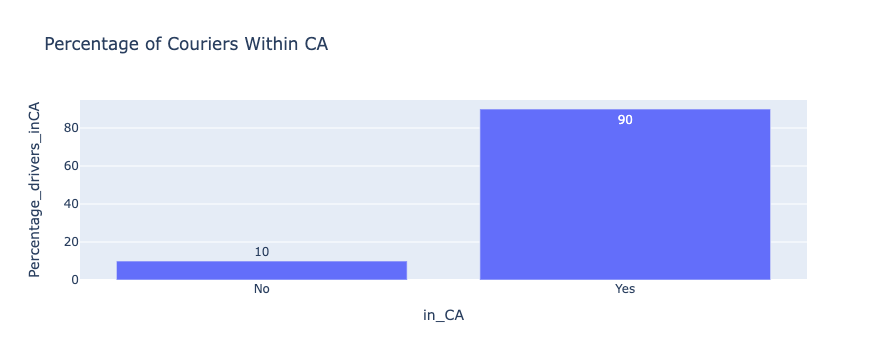

In [449]:
fig1 = px.bar(in_CA, x = 'in_CA' , y = 'Percentage_drivers_inCA', title= 'Percentage of Couriers Within CA', text = 'Percentage_drivers_inCA')
fig1.show()

In [450]:
# Top 5 CA with highest number of resident couriers
top_5_CA = courier_mapping.groupby('catchment_area').agg({'stuart_driver_id':'count'}).reset_index()
top_5_CA.head(5)

,catchment_area,stuart_driver_id
0,Altrincham,1
1,Basildon,2
2,Birmingham Central,3
3,Birmingham East,1
4,Bolton,2


In [451]:
# Sorting values in descending order
top_5_CA = top_5_CA.sort_values(by='stuart_driver_id', ascending=False)
top_5_CA.head(5)

,catchment_area,stuart_driver_id
36,London Outer NE,997
35,London Outer N,975
40,London Outer Upper NW,845
30,London Inner S,794
37,London Outer S,619


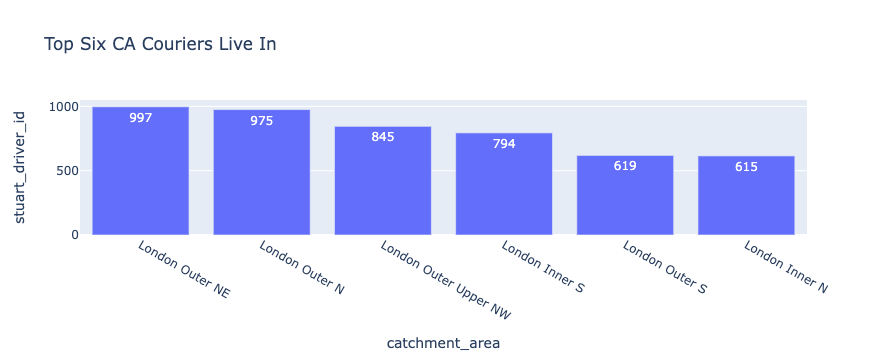

In [452]:
fig2 = px.bar(top_5_CA.head(6), x = 'catchment_area' , y = 'stuart_driver_id', title = 'Top Six CA Couriers Live In' , text = 'stuart_driver_id')
fig2.show()

# PC Mapping

###  Database used:

modeled_core.driver, 
modeled_core.delivery,
modeled_core.zones,
modeled_core.packages,
modeled_core.location,
ops.area,
ops.uk_application_mapping

In [524]:
query_2 = '''

SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
    MIN(cd.valid_from_date) as earliest_date,
       a.catchment_area as pu_CA,

    ------------------  Driver
       uam.postcode_found as driver_postCode,
       ad.catchment_area as driver_CA,
       count( distinct p.package_id) as no_packages,
       uam.application_fountain_id

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages

LEFT JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = cd.applicant_fountain_id

LEFT JOIN ops.area ad
    ON uam.application_pool = ad.area_name_uscore   -- pool area for driver ca

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-01-01'

GROUP BY 1, 3, 4, 5, 7

'''

deliveries = get_data_from_warehouse(query_2)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [525]:
# Getting multiple rows per driver as they can work in different catchment areas
deliveries.shape

(134122, 7)

In [526]:
no_dup_deliveries = deliveries.drop_duplicates()
no_dup_deliveries.shape
# No duplicates

(134122, 7)

In [527]:
no_dup_deliveries['driver_id'].nunique()

46481

In [528]:
# checking how many drivers have application_fountain_id as non-NULL
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['application_fountain_id'].isnull()==False]
no_dup_deliveries['driver_id'].nunique()


# 14109 have application_fountain_id as non-NULL

17554

In [529]:
# percentage of drivers who are not considered due to application_id
(45915 - 14109)/45915 * 100

69.27147990852663

In [530]:
# Generating a csv file with drivers and their deliveries
no_dup_deliveries.to_csv('data/deliveries_and_catchement_areas.csv' , index = False )

# Another way deliveries.to_csv('deliveries.csv') 

In [531]:
# Dropped all None values in driver_ca: Removing drivers who don't live in CA
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['driver_ca'].isnull()==False]

In [532]:
no_dup_deliveries['driver_id'].nunique()

14525

In [462]:
no_dup_deliveries.head(5)

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
17,350292,2021-01-25,London Inner Upper NW,NW10 1NP,London Inner Upper NW,4232,672d7fdd-8e85-4be6-a609-9eddf585cf83
28,376918,2021-03-15,London Outer N,N17 8JX,London Outer N,62,60077b0e-d219-4e0d-9d3b-3d46b3114962
41,388483,2021-04-14,Nottingham North,NG6 0BP,Nottingham North,2630,37abbd20-3ed8-4d3e-a9ec-562fbafe9fd6
65,345788,2021-01-18,London Outer E,DA8 1FE,London Outer E,185,146a8a7e-8033-425d-9658-128ecf731487
78,374296,2021-03-09,London Inner Lower NW,TW3 2PB,London Border W,1585,761c4499-83c0-4a07-921a-676aaf5cba02


In [534]:
# One driver could do deliveries in multiple CA
no_dup_deliveries.shape

(36369, 7)

In [535]:
# Checking example. Making sure there are no duplicates
no_dup_deliveries[no_dup_deliveries['driver_id']== 412933]

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
45705,412933,2021-06-14,Milton Keynes,PL1 5AE,Plymouth,202,934961ce-3b80-4144-9287-a8257ff2a0aa
65424,412933,2021-06-14,Plymstock,PL1 5AE,Plymouth,291,934961ce-3b80-4144-9287-a8257ff2a0aa
81825,412933,2021-06-14,Plymouth,PL1 5AE,Plymouth,383,934961ce-3b80-4144-9287-a8257ff2a0aa


In [536]:
# New column: total number of packages each driver did
new_df = no_dup_deliveries.groupby(['driver_id', 'driver_ca']).sum('no_packages').reset_index()

# Merging two datasets
mapped = pd.merge(no_dup_deliveries, new_df, left_on = ['driver_id','driver_ca']
                  , right_on = ['driver_id','driver_ca'])
mapped.head(5)

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages_x,application_fountain_id,no_packages_y
0,345954,2021-01-18,Teesside,TS1 4PY,Teesside,4430,2632459a-cc59-4e20-a034-9051d9f94232,4480
1,345954,2021-01-18,Newcastle,TS1 4PY,Teesside,21,2632459a-cc59-4e20-a034-9051d9f94232,4480
2,345954,2021-01-18,Gateshead,TS1 4PY,Teesside,29,2632459a-cc59-4e20-a034-9051d9f94232,4480
3,350348,2021-01-25,London Inner N,NW3 3PL,London Inner N,45,bd93df89-48d7-481b-9b13-f46a29a82b14,474
4,350348,2021-01-25,London Inner Upper NW,NW3 3PL,London Inner N,425,bd93df89-48d7-481b-9b13-f46a29a82b14,474


In [537]:
mapped['driver_id'].nunique()

14525

In [538]:
# Renaming columns for clarity
mapped = mapped.rename(columns = {'no_packages_x' : 'nb_packages_per_CA', 'no_packages_y' : 'total_nb_packages'})
mapped.head(5)


,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,nb_packages_per_CA,application_fountain_id,total_nb_packages
0,345954,2021-01-18,Teesside,TS1 4PY,Teesside,4430,2632459a-cc59-4e20-a034-9051d9f94232,4480
1,345954,2021-01-18,Newcastle,TS1 4PY,Teesside,21,2632459a-cc59-4e20-a034-9051d9f94232,4480
2,345954,2021-01-18,Gateshead,TS1 4PY,Teesside,29,2632459a-cc59-4e20-a034-9051d9f94232,4480
3,350348,2021-01-25,London Inner N,NW3 3PL,London Inner N,45,bd93df89-48d7-481b-9b13-f46a29a82b14,474
4,350348,2021-01-25,London Inner Upper NW,NW3 3PL,London Inner N,425,bd93df89-48d7-481b-9b13-f46a29a82b14,474


In [539]:
# Reordering and selecting needed columns for readability
mapped = mapped[['driver_id', 'driver_postcode' , 'driver_ca' , 'pu_ca' , 'nb_packages_per_CA' , 'total_nb_packages']].copy()
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,345954,TS1 4PY,Teesside,Teesside,4430,4480
1,345954,TS1 4PY,Teesside,Newcastle,21,4480
2,345954,TS1 4PY,Teesside,Gateshead,29,4480
3,350348,NW3 3PL,London Inner N,London Inner N,45,474
4,350348,NW3 3PL,London Inner N,London Inner Upper NW,425,474
...,...,...,...,...,...,...
36364,479696,M19 3LB,Manchester City,Manchester City,1,1
36365,488881,WA2 7JE,Warrington City,Warrington City,1,1
36366,398891,BR2 9TU,London Outer SE,London Outer SE,1,1
36367,447276,NE4 9QA,Newcastle,Gateshead,1,1


            Creating a metric to get "CA each driver mostly worked in"

In [540]:
# number of drives that did 0 deliveries in their own (applied) catchment area 
len(set(mapped[mapped['driver_ca'] != mapped['pu_ca']]['driver_id']).difference(mapped_filter['driver_id']))

1891

# Most Deliveries Metric

### Metric: mostly_worked_in_ca by choosing the CA where a courier did his most deliveries in. 
### Then compare if this CA is the same as driver ca as 1 or 0. 
### Then calculate the % of 1s 

In [541]:
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,345954,TS1 4PY,Teesside,Teesside,4430,4480
1,345954,TS1 4PY,Teesside,Newcastle,21,4480
2,345954,TS1 4PY,Teesside,Gateshead,29,4480
3,350348,NW3 3PL,London Inner N,London Inner N,45,474
4,350348,NW3 3PL,London Inner N,London Inner Upper NW,425,474
...,...,...,...,...,...,...
36364,479696,M19 3LB,Manchester City,Manchester City,1,1
36365,488881,WA2 7JE,Warrington City,Warrington City,1,1
36366,398891,BR2 9TU,London Outer SE,London Outer SE,1,1
36367,447276,NE4 9QA,Newcastle,Gateshead,1,1


In [542]:
# New df is the same as mapped
new_metric = mapped.copy()
new_metric.head(5)

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages
0,345954,TS1 4PY,Teesside,Teesside,4430,4480
1,345954,TS1 4PY,Teesside,Newcastle,21,4480
2,345954,TS1 4PY,Teesside,Gateshead,29,4480
3,350348,NW3 3PL,London Inner N,London Inner N,45,474
4,350348,NW3 3PL,London Inner N,London Inner Upper NW,425,474


In [543]:
#Obtaining max number of deliveries made in CA to check for later where a courier did his most deliveries in. 
new_metric['max_ca_deliveries']= new_metric.groupby(['driver_id'])['nb_packages_per_CA'].transform(max)
new_metric.head(5)

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries
0,345954,TS1 4PY,Teesside,Teesside,4430,4480,4430
1,345954,TS1 4PY,Teesside,Newcastle,21,4480,4430
2,345954,TS1 4PY,Teesside,Gateshead,29,4480,4430
3,350348,NW3 3PL,London Inner N,London Inner N,45,474,425
4,350348,NW3 3PL,London Inner N,London Inner Upper NW,425,474,425


In [544]:
# Metric: Create a column: mostly_worked_in_ca by choosing the CA where a courier did most of his deliveries. 

new_metric2 = new_metric[new_metric['nb_packages_per_CA'] == new_metric['max_ca_deliveries']].copy()
new_metric2.head(5)


,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries
0,345954,TS1 4PY,Teesside,Teesside,4430,4480,4430
4,350348,NW3 3PL,London Inner N,London Inner Upper NW,425,474,425
6,370480,HD1 4AW,Huddersfield,Huddersfield,2731,2731,2731
7,354978,NE13 6PA,Newcastle,Newcastle,793,794,793
9,376926,SR2 9RP,Sunderland,Sunderland,411,425,411


In [545]:
new_metric2[new_metric2['driver_id'].duplicated()]['driver_id']

6218     350251
6219     350251
14293    392848
14883    462754
16240    493944
          ...  
36154    495044
36167    477405
36185    392845
36193    402394
36247    363376
Name: driver_id, Length: 84, dtype: int64

Received duplicates (14,196 insteatd of 14,109 as some drivers did equal number of deliveres in two CA). Solution is to drop these as they compose less than 1% of couriers.

In [546]:
########### Can just drop duplicate drivers id

In [547]:
# Then compare if this CA is the same as driver ca as 1 or 0. 
new_metric2['is_same'] = np.where(new_metric2['pu_ca'] == new_metric2['driver_ca'], 1, 0)
new_metric2

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,total_nb_packages,max_ca_deliveries,is_same
0,345954,TS1 4PY,Teesside,Teesside,4430,4480,4430,1
4,350348,NW3 3PL,London Inner N,London Inner Upper NW,425,474,425,0
6,370480,HD1 4AW,Huddersfield,Huddersfield,2731,2731,2731,1
7,354978,NE13 6PA,Newcastle,Newcastle,793,794,793,1
9,376926,SR2 9RP,Sunderland,Sunderland,411,425,411,1
...,...,...,...,...,...,...,...,...
36364,479696,M19 3LB,Manchester City,Manchester City,1,1,1,1
36365,488881,WA2 7JE,Warrington City,Warrington City,1,1,1,1
36366,398891,BR2 9TU,London Outer SE,London Outer SE,1,1,1,1
36367,447276,NE4 9QA,Newcastle,Gateshead,1,1,1,0


In [548]:
# Then calculate the % of 1s 
new_metric2.describe()

# 74% of drivers who live in CA mostly do deliveries in their CA

,driver_id,nb_packages_per_CA,total_nb_packages,max_ca_deliveries,is_same
count,14609.000000,14609.000000,14609.000000,14609.000000,14609.000000
mean,427583.514957,634.760764,700.796701,634.760764,0.733384
std,43970.588040,928.363362,1001.407327,928.363362,0.442205
min,339107.000000,1.000000,1.000000,1.000000,0.000000
25%,395629.000000,47.000000,54.000000,47.000000,0.000000
50%,427762.000000,234.000000,263.000000,234.000000,1.000000
75%,467733.000000,832.000000,942.000000,832.000000,1.000000
max,501306.000000,8918.000000,10945.000000,8918.000000,1.000000


# Drivers who did not live in CA

need a Predicted_CA column from ops.uk_applicant

In [549]:
query_3 = '''

SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
  --   MIN(cd.valid_from_date) as earliest_date,
       uai.applicant_fountain_id,
       a.catchment_area as pu_CA,

    ------------------  Driver
    predicted_catchment_area as predicted_driver_CA,
       count( distinct p.package_id) as no_packages

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages


LEFT JOIN ops.uk_applicants_info uai
    ON uai.applicant_fountain_id = cd.applicant_fountain_id

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-01-01'

GROUP BY 1, 2, 3,4

'''


predicted = get_data_from_warehouse(query_3)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [550]:
# Getting multiple rows per driver as they can work in different catchment areas
predicted.shape

(134720, 5)

In [551]:
no_dup_predicted = predicted.drop_duplicates()
no_dup_predicted.shape
# No duplicates

(134720, 5)

In [552]:
# Number of individual drivers
no_dup_predicted['driver_id'].nunique()

46481

In [553]:
# checking how many drivers have application_fountain_id as non-NULL
no_dup_predicted = no_dup_predicted[no_dup_predicted['applicant_fountain_id'].isnull()==False]
no_dup_predicted['driver_id'].nunique()

# 45,690 have application_fountain_id as non-NULL

46254

In [554]:
# percentage of drivers who are not considered due to application_id
(45915 - 45690)/45915 * 100

0.4900359359686377

In [555]:
# Generating a csv file with drivers and their deliveries
no_dup_predicted.to_csv('data/deliveries&_predicted_CA.csv' , index = False )

In [556]:
no_dup_predicted.head(5)

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
0,297416,eaa645d3-28f3-49d2-80d4-cfb2c580a1c8,Newcastle,None,330
1,320287,ff9c1a30-d4e5-48f0-baeb-d6b11e168373,Leicester,None,772
2,84091,1c976276-4f1d-42f2-9847-ee2a9c294be0,Darlington,None,4556
3,251278,e261c5c6-ac98-4953-823c-9ae457a9fa76,London Inner N,None,460
4,147822,c088179a-a51a-4f80-8e40-9a37210bbb83,London Inner S,None,2362


In [557]:
# Replacing None with Null in predicted_catchment_area
no_dup_predicted.predicted_driver_ca.fillna(value=np.nan, inplace=True)
no_dup_predicted.head(5)

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
0,297416,eaa645d3-28f3-49d2-80d4-cfb2c580a1c8,Newcastle,NaN,330
1,320287,ff9c1a30-d4e5-48f0-baeb-d6b11e168373,Leicester,NaN,772
2,84091,1c976276-4f1d-42f2-9847-ee2a9c294be0,Darlington,NaN,4556
3,251278,e261c5c6-ac98-4953-823c-9ae457a9fa76,London Inner N,NaN,460
4,147822,c088179a-a51a-4f80-8e40-9a37210bbb83,London Inner S,NaN,2362


In [558]:
# Dropped all None values in predicted_driver_ca: Removing drivers whose predicted_CA is Null
no_null_predicted = no_dup_predicted[no_dup_predicted['predicted_driver_ca'].isnull()==False]
no_null_predicted.head(5)

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
79,358532,1296da29-5baf-42bc-b014-67116b5d8b45,London Outer SW,London Outer SW,722
111,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,London Outer E,London Outer E,2128
170,350147,9f1e9d03-d8d0-4c27-bae6-5dd6f52dd658,Chesterfield,Sheffield,3719
187,394472,f08ae3e2-5b1c-4fdd-a045-90053333a44f,London Inner N,London Inner Lower NW,2
189,355083,5b9587d3-d691-463f-a15d-d80e88cb1499,Sheffield,Chesterfield,4513


In [559]:
# Number of individual drivers left
no_null_predicted['driver_id'].nunique()

# 8358/45690 *100 = 18.29%

8834

In [560]:
# Checking example. Making sure there are no duplicates
no_null_predicted[no_null_predicted['driver_id']== 459459]

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
77895,459459,3a3d61b7-e3a9-4fff-a373-425815665caa,Derby,Derby,472


In [561]:
# New column: total number of packages each driver did
total_pkgs = no_null_predicted.groupby(['driver_id', 'predicted_driver_ca']).sum('no_packages').reset_index()

# Merging two datasets
merged = pd.merge(no_null_predicted, total_pkgs, left_on = ['driver_id','predicted_driver_ca']
                  , right_on = ['driver_id','predicted_driver_ca'])
merged.head(5)

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages_x,no_packages_y
0,358532,1296da29-5baf-42bc-b014-67116b5d8b45,London Outer SW,London Outer SW,722,725
1,358532,1296da29-5baf-42bc-b014-67116b5d8b45,None,London Outer SW,3,725
2,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,London Outer E,London Outer E,2128,2134
3,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,London Inner E,London Outer E,5,2134
4,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,None,London Outer E,1,2134


In [562]:
# Renaming columns for clarity
merged = merged.rename(columns = {'no_packages_x' : 'nb_pkgs_per_predict_CA', 'no_packages_y' : 'total_nb_packages' , 'zone_name' : 'zone_name_of_driver_pu_ca'})
merged.head(5)


,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,total_nb_packages
0,358532,1296da29-5baf-42bc-b014-67116b5d8b45,London Outer SW,London Outer SW,722,725
1,358532,1296da29-5baf-42bc-b014-67116b5d8b45,None,London Outer SW,3,725
2,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,London Outer E,London Outer E,2128,2134
3,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,London Inner E,London Outer E,5,2134
4,346539,fc09fa3d-efc8-46b8-93e2-6094051eaa96,None,London Outer E,1,2134


In [563]:
# Dropping columns we don't need
clean = merged.drop(columns=['applicant_fountain_id'])
clean.head(5)

,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,total_nb_packages
0,358532,London Outer SW,London Outer SW,722,725
1,358532,None,London Outer SW,3,725
2,346539,London Outer E,London Outer E,2128,2134
3,346539,London Inner E,London Outer E,5,2134
4,346539,None,London Outer E,1,2134


            Creating a metric to get "CA each driver mostly worked in where each driver who does not live in a CA"

In [564]:
# New df is the same as clean
metric_df = clean.copy()
metric_df.head(5)

,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,total_nb_packages
0,358532,London Outer SW,London Outer SW,722,725
1,358532,None,London Outer SW,3,725
2,346539,London Outer E,London Outer E,2128,2134
3,346539,London Inner E,London Outer E,5,2134
4,346539,None,London Outer E,1,2134


In [565]:
#Obtaining max number of deliveries made in CA to check for later if a courier did his most deliveries in predicted CA 
metric_df['max_ca_deliveries']= metric_df.groupby(['driver_id'])['nb_pkgs_per_predict_CA'].transform(max)
metric_df.head(5)


,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,total_nb_packages,max_ca_deliveries
0,358532,London Outer SW,London Outer SW,722,725,722
1,358532,None,London Outer SW,3,725,722
2,346539,London Outer E,London Outer E,2128,2134,2128
3,346539,London Inner E,London Outer E,5,2134,2128
4,346539,None,London Outer E,1,2134,2128


In [566]:
# Metric: Create a column: mostly_worked_in_ca by choosing the CA where a courier did most of his deliveries. 

metric_final = metric_df[metric_df['nb_pkgs_per_predict_CA'] == metric_df['max_ca_deliveries']].copy()
metric_final


,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,total_nb_packages,max_ca_deliveries
0,358532,London Outer SW,London Outer SW,722,725,722
2,346539,London Outer E,London Outer E,2128,2134,2128
5,350147,Chesterfield,Sheffield,3719,3782,3719
9,394472,London Inner Lower NW,London Inner Lower NW,461,505,461
15,355083,Sheffield,Chesterfield,4513,5429,4513
...,...,...,...,...,...,...
18479,500135,London Inner S,London Outer Lower NW,1,1,1
18480,455480,London Inner E,London Inner E,1,1,1
18481,468244,None,Bristol Central Area,1,1,1
18482,477084,London Outer N,London Border N,1,1,1


In [567]:
metric_final[metric_final['driver_id'].duplicated()]['driver_id']

3356     485909
4562     473199
5083     454789
5772     464691
6592     485268
          ...  
18165    469442
18195    408428
18200    465229
18224    466353
18412    462518
Name: driver_id, Length: 66, dtype: int64

Received duplicates (66 drivers did equal number of deliveres in two CA). Solution is to drop these as they compose less than 1% of couriers.

In [568]:
# Then compare if this CA is the same as driver ca as 1 or 0. 
metric_final['is_same'] = np.where(metric_final['pu_ca'] == metric_final['predicted_driver_ca'], 1, 0)
metric_final.head(5)

,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,total_nb_packages,max_ca_deliveries,is_same
0,358532,London Outer SW,London Outer SW,722,725,722,1
2,346539,London Outer E,London Outer E,2128,2134,2128,1
5,350147,Chesterfield,Sheffield,3719,3782,3719,0
9,394472,London Inner Lower NW,London Inner Lower NW,461,505,461,1
15,355083,Sheffield,Chesterfield,4513,5429,4513,0


In [569]:
# Then calculate the % of 1s 
metric_final.describe()

# 69% of drivers who live in CA mostly do deliveries in their CA

,driver_id,nb_pkgs_per_predict_CA,total_nb_packages,max_ca_deliveries,is_same
count,8900.000000,8900.000000,8900.000000,8900.000000,8900.000000
mean,457448.333820,283.693820,309.051124,283.693820,0.690112
std,34719.127117,470.198732,511.221966,470.198732,0.462473
min,339107.000000,1.000000,1.000000,1.000000,0.000000
25%,449022.000000,26.000000,29.000000,26.000000,0.000000
50%,466182.500000,113.000000,125.000000,113.000000,1.000000
75%,481165.250000,338.000000,373.000000,338.000000,1.000000
max,501306.000000,7705.000000,10945.000000,7705.000000,1.000000
